## Requerimiento 1
**implementacion de la arquitectura cluster con un set de 3 replicas**
- Mapeamos los puertos que vamos a utilizar en nuestra IP local conectandonos a la terminal y agregando los puertos

In [ ]:
# En linux:
sudo nano /etc/hosts

 Desde aqui, nos aparecera la instancia de nuestro host, asi que integramos los puertos que usaremos agregando este codigo al final

In [ ]:
127.0.0.1 mongo1
127.0.0.1 mongo2
127.0.0.1 mongo3

- Ejecutamons nuestro codigo deploy-202273503-1-202273641-0.yml para configurar los contenedores usando en la terminal el comando 
`docker compose -f deploy-202273503-1-202273641-0.yml up -d`

In [ ]:
# deploy-202273503-1-20227361-0.yml

version: "3.8"

services:
  mongo1:
    image: mongo:5
    container_name: mongo1
    command: ["--replSet", "my-replica-set", "--bind_ip_all", "--port", "30001"]
    volumes:
      - ./data/mongo-1:/data/db
    ports:
      - 30001:30001
    healthcheck:
      test: test $$(echo "rs.initiate({_id:'my-replica-set',members:[{_id:0,host:\"mongo1:30001\"},{_id:1,host:\"mongo2:30002\"},{_id:2,host:\"mongo3:30003\"}]}).ok || rs.status().ok" | mongo --port 30001 --quiet) -eq 1
      interval: 10s
      start_period: 30s

  mongo2:
    image: mongo:5
    container_name: mongo2
    command: ["--replSet", "my-replica-set", "--bind_ip_all", "--port", "30002"]
    volumes:
      - ./data/mongo-2:/data/db
    ports:
      - 30002:30002

  mongo3:
    image: mongo:5
    container_name: mongo3
    command: ["--replSet", "my-replica-set", "--bind_ip_all", "--port", "30003"]
    volumes:
      - ./data/mongo-3:/data/db
    ports:
      - 30003:30003


Con esto deberiamos tener nuestros contenedores arriba y ser visible en nuestro docker desktop ✅

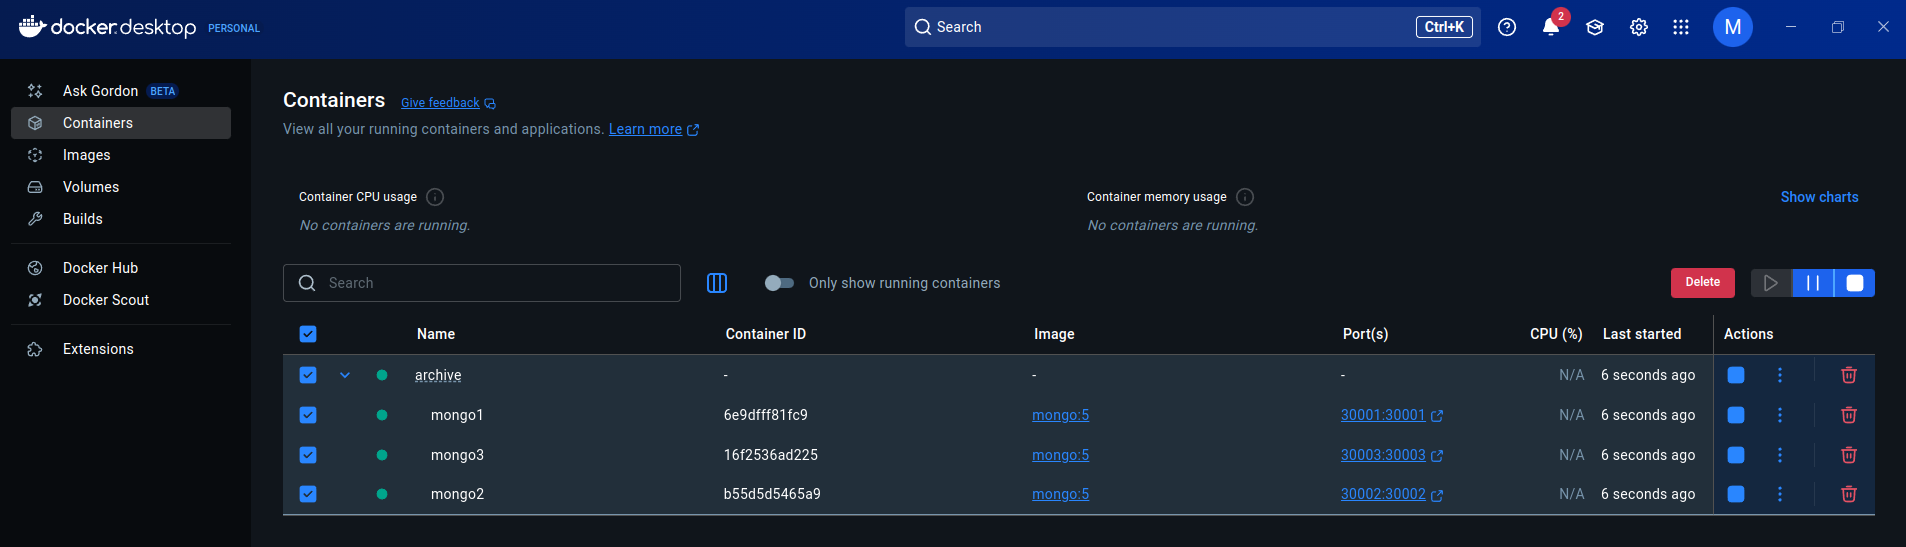
- Ahora poblaremos de articulos nuestro set utilizando el siguiente codigo de python

In [ ]:
# arXiv_edited.py

# === librerias ===
import json
from pymongo import MongoClient
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# === Configuración ===
json_file_path = "arxiv-metadata-oai-snapshot.json"
#Estas variables manejarlas segun la potencia del pc
batch_size = 2000   # Modificar segun la potencia del PC, mayor el numero => mayor velocidad de subida
max_workers = 8     # tener en cuenta los nucleos logicos de tu PC
max_pending_batches = max_workers * 2 # Mantenlo como multiplo de max_workers, en este caso seran 16

# === Conectar a MongoDB ===
#nos conectamos a los puertos de nuestro set
client = MongoClient("mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client["arxiv_db"]
collection = db["articles"]

# === Función para insertar lote ===
def insert_batch(batch):
    try:
        collection.insert_many(batch, ordered=False)
    except Exception as e:
        print("Error al insertar batch:", e)

# === Lectura + carga paralela ===
with open(json_file_path, 'r', encoding='utf-8') as f, tqdm(desc="Cargando artículos") as pbar:
    current_batch = []
    pending_futures = [] # Lista para almacenar los objetos Future

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for line_num, line in enumerate(f): # line_num puede ser útil para depuración
            try:
                record = json.loads(line)
                # 👉 Agregar campo pdf_source
                record["pdf_source"] = f"https://arxiv.org/pdf/{record['id']}"
                current_batch.append(record)

                if len(current_batch) >= batch_size:
                    # Envia el lote para inserción y guarda el Future
                    future = executor.submit(insert_batch, list(current_batch)) # Se pasa una copia del batch
                    pending_futures.append(future)
                    current_batch = [] # Reinicia el lote

                    # === Control de flujo: Esperar si hay demasiados lotes pendientes ===
                    if len(pending_futures) >= max_pending_batches:
                        # Espera a que las tareas más antiguas se completen
                        # as_completed devuelve los futures a medida que se completan
                        for completed_future in as_completed(pending_futures):
                            try:
                                completed_future.result() # Obtiene el resultado (o re-lanza excepción)
                            except Exception as e:
                                print(f"Error en una tarea completada: {e}")
                            # Una vez que una tarea se completa, la eliminamos de la lista
                            pending_futures.remove(completed_future)
                            # Si ya no tenemos demasiados lotes pendientes, podemos seguir enviando
                            if len(pending_futures) < max_pending_batches:
                                break # Salir del bucle interno y continuar leyendo líneas

            except json.JSONDecodeError:
                # Omitir líneas que no son JSON válido, pero considera registrarlo si es inesperado
                # print(f"Saltando línea JSON mal formada en la línea {line_num + 1}: {line.strip()}")
                continue
            pbar.update(1) # Actualiza la barra de progreso por cada línea procesada

        # === Último batch (si queda algo después del bucle) ===
        if current_batch:
            future = executor.submit(insert_batch, list(current_batch))
            pending_futures.append(future)

        # === Esperar a que terminen todas las cargas restantes ===
        # Fuera del bucle principal, esperamos a que todas las tareas pendientes finalicen
        for completed_future in as_completed(pending_futures):
            try:
                completed_future.result()
            except Exception as e:
                print(f"Error en una tarea final pendiente: {e}")

print("✅ Carga paralela completa.")

Codigo para borrar los articulos de los contenedores

In [ ]:
'''
from pymongo import MongoClient

client = MongoClient("mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client["arxiv_db"]
collection = db["articles"]

# ⚠️ Eliminar todos los documentos
collection.delete_many({})
print("🗑️ Todos los documentos eliminados.")
'''

Con esto ya tendriamos poblado los articulos en nuestros conteiner ✅, podemos visualizar los datos tanto desde la terminal como desde MongoDB Compass. En caso del segundo solo bastaria con usar la direccion de los puertos `mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&ssl=false`

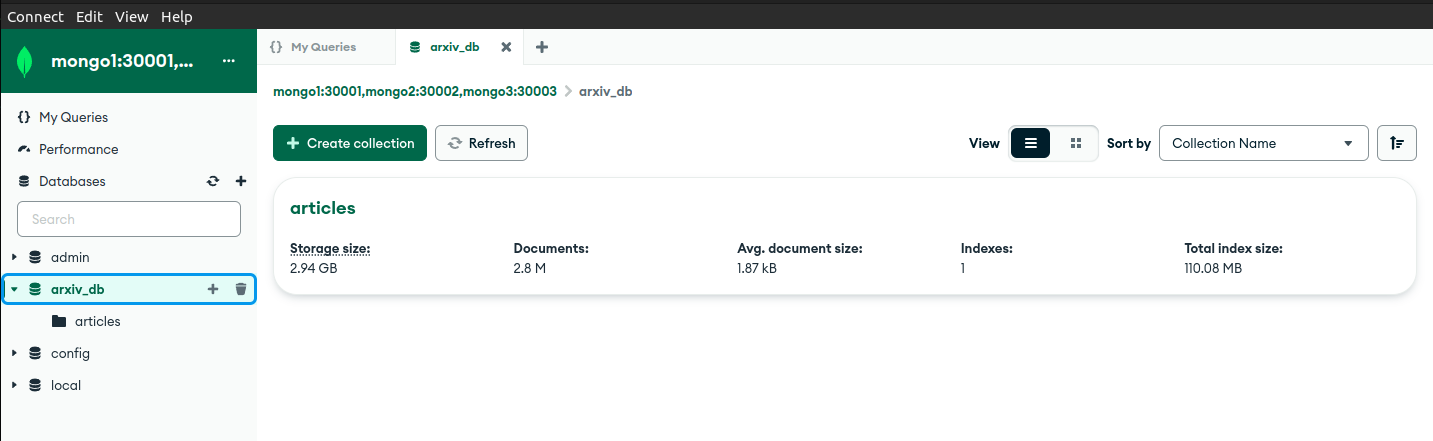